# A Predictive Model for Formation Enthalpy

Predict the formation enthalpy (a measure of energetic stability) of several crystalline compounds using a machine learning model based on method by [Ward et al.](https://www.nature.com/articles/npjcompumats201628) and data from the OQMD. Here, we show all three steps of running the model - parsing a string to a [pymatgen](http://pymatgen.org/) object, using [matminer](https://hackingmaterials.github.io/matminer/) to compute features, and running a [scikit-learn](http://scikit-learn.org/stable/) model - as independent steps, but you can also execute the entire pipeline as a single call.

![pipeline](img/formation_enthalpy_pipeline.png)


In [1]:
import requests
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
%matplotlib inline

## MDF and DLHub imports
from mdf_forge.forge import Forge
import mdf_toolbox
from dlhub_sdk.client import DLHubClient

## Instantiate clients and handle authentication

In [2]:
mdf = Forge()
dl = DLHubClient()
creds = mdf_toolbox.login(app_name="DLHub", services=["petrel", "data_mdf", "transfer"])

AuthAPIError: (400, 'Error', 'invalid_grant')

### Get data from MDF

Gather the composition of a few Al-Cu compounds for which we will predict the formation enthalpy.

In [3]:
res = mdf.search_by_elements(elements=["Al","Cu"], 
                                 source_names=["oqmd"], 
                                 limit=20)
compositions = [{"composition":r['material']['composition']} for r in res]
df = pd.DataFrame(compositions)
df.head()

NameError: name 'mdf' is not defined

Our dataframe now contains the composition of our materials

### Query DLHub to Find the Model Steps
The `get_servables` command returns a list of all of the servables available in DLHub. Each servable is identified by a human-friendly name and human-unfriendly UUID that is required by the service, but we provide operations so that you don't need to remember it.

In [11]:
df_serv = dl.get_servables()
df_serv[['uuid', 'name']]

,uuid,name
0,1117ac20-3f54-11e8-b467-0ed5f89f718b,oqmd_model
1,9ff7a98c-3f54-11e8-b467-0ed5f89f718b,matminer_featurize
2,d5a1653c-3ec5-4947-8c5a-28f6554ec339,matminer_util
3,9553d6a2-6a8d-4cda-8b81-7f38efab67e7,formation_energy
4,78d08664-5d52-44a0-b2c8-47cf702b2e39,DLSCORE
5,3a07b0f9-6507-47de-9e42-267ac82a72de,DSIR
6,1e19a78d-547c-483b-9b75-e1ae272a50d6,deep_smiles
7,8c78939e-6422-4627-80ea-03ed8bfdf6ea,metallic_glass
8,e127fb16-5852-11e8-9c2d-fa7ae01bbebc,yager_xrd_classifier


Out of these, we can easily find the first step in our pipeline: the parser conversion

In [12]:
servable_name = "matminer_util"
servable_id = dl.get_id_by_name(servable_name)
print('Our first step is ID:', servable_id)

Our first step is ID: d5a1653c-3ec5-4947-8c5a-28f6554ec339


### Convert the Compositions to Pymatgen Objects
The first step in running the formation enthalpy model is to take a string, and parse it to a pymatgen Composition object that works with our next step in the toolchain. We seperate this part from the later steps in the pipeline so that other tools could reuse the Composition parser, and we can do some clever pipelining to make the models faster. Normally, you don't need to know this part exists. 

![pipeline](img/formation_enthalpy_1.png)

In [13]:
comps = []
for i, row in tqdm(df.iterrows(), total=len(df)):
    data = {"data":[{"composition":row['composition']}]}
    res = dl.run(servable_id, data)
    comps.append(res['composition_object'][0])
df['composition_object'] = comps
df.head(2)

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

,composition,composition_object
0,Al1Cu4,gANjcHltYXRnZW4uY29yZS5jb21wb3NpdGlvbgpDb21wb3...
1,Al1Cu1,gANjcHltYXRnZW4uY29yZS5jb21wb3NpdGlvbgpDb21wb3...


DLHub uses JSON to communicate between processes. As Python objects are not normally JSON-serializable, we first convert it to a `base64` string representation before sending it back to you. You can pretend this does not exist.

### Use Matminer to Compute Features
The key step of building a machine learning models of materials data is to compute informative inputs. For the composition of a material, these are things like the average radius of each of the atoms. We compute 145 of such features using matminer.

![pipeline](img/formation_enthalpy_2.png)

In [14]:
servable_name = "matminer_featurize"
servable_id = dl.get_id_by_name(servable_name)
features = [] 

for i, row in tqdm(df.iterrows(), total=len(df)):
    data = {"data":[{"composition_object":row['composition_object']}]}
    res = dl.run(servable_id, data)
    features.append(res['features'][0])

df['features'] = features
df.head()

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

,composition,composition_object,features
0,Al1Cu4,gANjcHltYXRnZW4uY29yZS5jb21wb3NpdGlvbgpDb21wb3...,"[13.0, 29.0, 16.0, 25.8, 5.119999999999999, 29..."
1,Al1Cu1,gANjcHltYXRnZW4uY29yZS5jb21wb3NpdGlvbgpDb21wb3...,"[13.0, 29.0, 16.0, 21.0, 8.0, 13.0, 64.0, 73.0..."
2,Al1Cu4,gANjcHltYXRnZW4uY29yZS5jb21wb3NpdGlvbgpDb21wb3...,"[13.0, 29.0, 16.0, 25.8, 5.119999999999999, 29..."
3,Al2Cu1,gANjcHltYXRnZW4uY29yZS5jb21wb3NpdGlvbgpDb21wb3...,"[13.0, 29.0, 16.0, 18.333333333333332, 7.11111..."
4,Al2Cu1,gANjcHltYXRnZW4uY29yZS5jb21wb3NpdGlvbgpDb21wb3...,"[13.0, 29.0, 16.0, 18.333333333333332, 7.11111..."


Note that the array now contains a column `features` where each entry is a list of different features that describe a material

## Run the Machine Learning Model
The last step is to invoke a scikit-learn model that takes the features to compute a formation enthalpy.

![pipeline](img/formation_enthalpy_3.png)

In [15]:
servable_name = "oqmd_model"
servable_id = dl.get_id_by_name(servable_name)
preds = []
for i, row in tqdm(df.iterrows(), total=len(df)):
    data = {"data":[{"features":row['features']}]}
    res = dl.run(servable_id, data)
    preds.append(res['prediction'][0])
df['prediction'] = preds
df.head()

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

,composition,composition_object,features,prediction
0,Al1Cu4,gANjcHltYXRnZW4uY29yZS5jb21wb3NpdGlvbgpDb21wb3...,"[13.0, 29.0, 16.0, 25.8, 5.119999999999999, 29...",-0.183846
1,Al1Cu1,gANjcHltYXRnZW4uY29yZS5jb21wb3NpdGlvbgpDb21wb3...,"[13.0, 29.0, 16.0, 21.0, 8.0, 13.0, 64.0, 73.0...",-0.179726
2,Al1Cu4,gANjcHltYXRnZW4uY29yZS5jb21wb3NpdGlvbgpDb21wb3...,"[13.0, 29.0, 16.0, 25.8, 5.119999999999999, 29...",-0.183846
3,Al2Cu1,gANjcHltYXRnZW4uY29yZS5jb21wb3NpdGlvbgpDb21wb3...,"[13.0, 29.0, 16.0, 18.333333333333332, 7.11111...",-0.221089
4,Al2Cu1,gANjcHltYXRnZW4uY29yZS5jb21wb3NpdGlvbgpDb21wb3...,"[13.0, 29.0, 16.0, 18.333333333333332, 7.11111...",-0.221089


Great! Now we've predicted the stability for all of the materials in our list

## Visualize the result
Just print out our materials with the lowest formation enthalpy, and make a histogram to see the distribution of energies

In [16]:
df.sort_values('prediction', ascending=True).head(3)

,composition,composition_object,features,prediction
19,Al3Cu1,gANjcHltYXRnZW4uY29yZS5jb21wb3NpdGlvbgpDb21wb3...,"[13.0, 29.0, 16.0, 17.0, 6.0, 13.0, 64.0, 73.0...",-0.234192
10,Al3Cu1,gANjcHltYXRnZW4uY29yZS5jb21wb3NpdGlvbgpDb21wb3...,"[13.0, 29.0, 16.0, 17.0, 6.0, 13.0, 64.0, 73.0...",-0.234192
5,Al3Cu1,gANjcHltYXRnZW4uY29yZS5jb21wb3NpdGlvbgpDb21wb3...,"[13.0, 29.0, 16.0, 17.0, 6.0, 13.0, 64.0, 73.0...",-0.234192


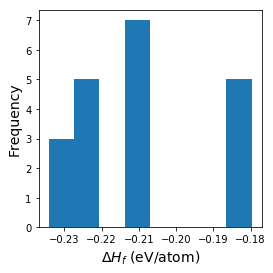

In [17]:
fig, ax = plt.subplots()

ax.hist(df['prediction'], bins=8)

ax.set_xlabel('$\Delta H_f$ (eV/atom)', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)

fig.set_size_inches(4, 4)

At this point, we've run a prediction of the stability of a few materials without ever having to install any software on our computer.